![GOT](./images/got-header.jpg)

In [1]:
from __future__ import absolute_import, division, print_function
import codecs
import glob
import multiprocessing
import os
import pprint
import re
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

C:\Users\dhava\AppData\Local\Continuum\Anaconda2\envs\neuralnets\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\dhava\AppData\Local\Continuum\Anaconda2\envs\neuralnets\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dhava\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dhava\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [19]:
FIRST_TIME = False

In [3]:
book_filenames = sorted(glob.glob('./data/*.txt'))
book_filenames

['./data\\001ssb.txt', './data\\002ssb.txt', './data\\003ssb.txt']

In [4]:
raw_corpus = u""
for book in book_filenames:
    print("Reading '{0}' ...".format(book))
    with codecs.open(book, 'r', 'utf-8') as book:
        raw_corpus += book.read()
        print("Corpus is now {0} characters long".format(len(raw_corpus)))
        print()

Reading './data\001ssb.txt' ...
Corpus is now 1628063 characters long

Reading './data\002ssb.txt' ...
Corpus is now 3436003 characters long

Reading './data\003ssb.txt' ...
Corpus is now 5786702 characters long



In [5]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
raw_sentences = tokenizer.tokenize(raw_corpus)

In [6]:
# Convert into list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [7]:
sentences = []
for sentence in raw_sentences:
    if len(sentence) > 0:
        sentences.append(sentence_to_wordlist(sentence))

In [8]:
print(raw_sentences[10])
print(sentence_to_wordlist(raw_sentences[10]))

"What proof have we?"
['What', 'proof', 'have', 'we']


In [9]:
token_count = sum([len(sentence) for sentence in sentences])
print("The corpus contains {0:,} tokens".format(token_count))

The corpus contains 1,062,095 tokens


In [20]:
if FIRST_TIME:
    num_features = 300
    min_word_count = 3
    num_workers = multiprocessing.cpu_count()
    context_size = 7
    downsampling = 1e-3
    seed = 1

    thrones2vec = w2v.Word2Vec(
        sg = 1,
        seed = seed,
        workers = num_workers,
        size = num_features,
        min_count = min_word_count,
        window = context_size,
        sample = downsampling
    )

    thrones2vec.build_vocab(sentences)
    thrones2vec.train(sentences, total_examples = thrones2vec.corpus_count, epochs = thrones2vec.iter)
    if not os.path.exists('./trained'):
        os.makedirs('trained')
    thrones2vec.save(os.path.join("./trained", "thrones2vec.w2v"))
else:
    thrones2vec = w2v.Word2Vec.load(os.path.join("./trained", "thrones2vec.w2v"))

In [21]:
tsne = sklearn.manifold.TSNE(n_components = 2, random_state = 0)

In [22]:
all_word_vectors_matrix = thrones2vec.wv.syn0

In [23]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [24]:
points = pd.DataFrame(
    [
    (word, coords[0], coords[1])
    for word, coords in [
        (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
        for word in thrones2vec.wv.vocab
    
    ]
    ], columns = ["word", "x", "y"]
)

In [25]:
points.head()

,word,x,y
0,fawn,-17.038229,-4.845665
1,raining,23.744783,38.905060
2,mustachio,-2.978812,32.099258
3,Greyjoy,32.776863,-57.044407
4,both,1.525158,-7.414763


In [27]:
sns.set_context()

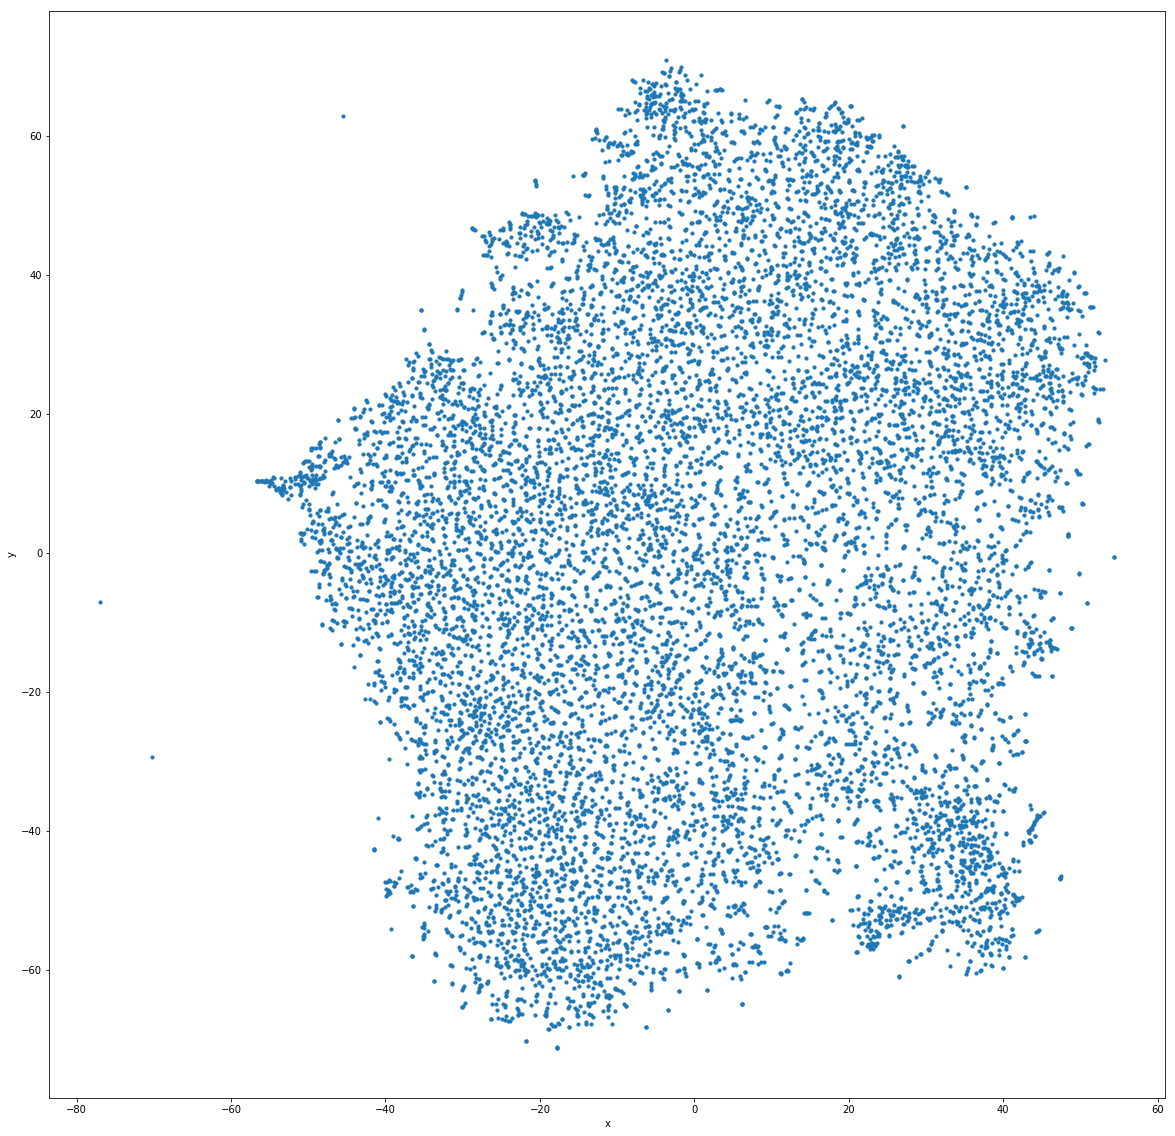

In [33]:
points.plot.scatter("x", "y", s =10, figsize = (20, 20))
plt.show()

In [53]:
def plot_region(x_bounds, y_bounds):
    tslice = points.loc[(points.loc[:, "x"] >= x_bounds[0]) & (points.loc[:, "x"] <= x_bounds[1]) &  (points.loc[:, "y"] >= y_bounds[0]) & (points.loc[:, "y"] <= y_bounds[1]), :]
#     tslice = points.loc[(x_bounds[0] <= points.x) & (points.x <= x_bounds[1])
#                     &
#         ((y_bounds[0] <= points.y) & (points.y <= y_bounds[1]))]
#     print(tslice.head())
    ax = tslice.plot.scatter("x", "y", s = 35, figsize = (10,8))
    for i, point in tslice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize = 10)

**Looking at the zoomed region of the above 2D representation of the word vectors. We can see that words like windy, autmn, snows are together.**

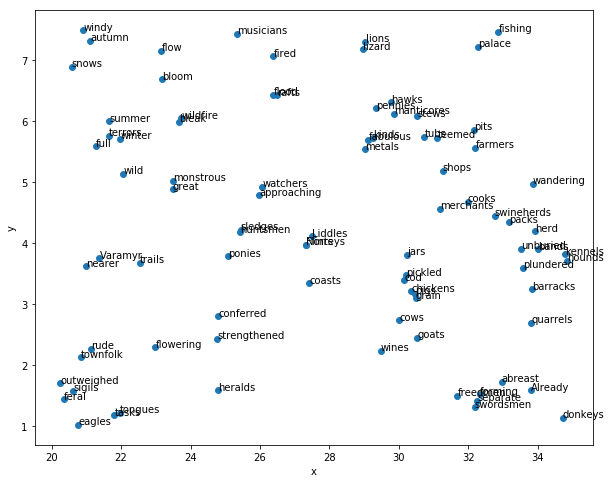

In [73]:
plot_region(x_bounds = (20, 35), y_bounds = (1, 7.5))
plt.show()
# points.dtypes

### Exploring semantic similarities between book characters

In [74]:
thrones2vec.most_similar("Stark")

[('Eddard', 0.7075438499450684),
 ('Lyanna', 0.7025941610336304),
 ('Benjen', 0.6847219467163086),
 ('Winterfell', 0.6610473394393921),
 ('Hornwood', 0.6568844318389893),
 ('Tully', 0.6521530151367188),
 ('Roslin', 0.6456855535507202),
 ('Brandon', 0.645483672618866),
 ('Bael', 0.643380880355835),
 ('Robb', 0.6422325372695923)]

In [76]:
thrones2vec.most_similar("Aerys")

[('Rhaegar', 0.8321652412414551),
 ('Targaryen', 0.830471396446228),
 ('knighted', 0.8012657165527344),
 ('Robert', 0.7990405559539795),
 ('Dome', 0.7933883666992188),
 ('Bael', 0.7919018268585205),
 ('Jaehaerys', 0.7889218330383301),
 ('Usurper', 0.7887647151947021),
 ('Daeron', 0.7878808975219727),
 ('reign', 0.786959171295166)]

**Linear relationships between word pairs**

In [77]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive = [end2, start1],
        negative = [end1]
    )
    start2 = similarities[0][0]
    print(start1 + " is related to " + end1 +" as " + start2 + " is related to " + end2)
    return start2

In [78]:
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")
nearest_similarity_cosmul("Dany", "Dragons", "Lannister")
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")

Stark is related to Winterfell as Tully is related to Riverrun
Dany is related to Dragons as Jaime is related to Lannister
Stark is related to Winterfell as Tully is related to Riverrun


'Tully'